We got inspiration from the following kaggle blog to build our model off of: https://www.kaggle.com/code/willkoehrsen/automated-model-tuning

In [3]:
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

N_FOLDS = 3
MAX_EVALS = 50

## Data Set-up

In [4]:
features = pd.read_csv('data/application_train.csv')

In [5]:
features = features.sample(n = 16000, random_state = 42)
features = features.select_dtypes('number')
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 50)

In [6]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (10000, 104)
Testing features shape:  (6000, 104)


In [7]:
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

In [8]:
%%capture

model = lgb.LGBMClassifier()
default_params = model.get_params()

del default_params['n_estimators']

cv_results = lgb.cv(default_params, train_set, num_boost_round = 100, metrics = 'auc', nfold = N_FOLDS, seed = 42)

In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
%%capture
model.n_estimators = len(cv_results['valid auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]

# Data Exploration

In [11]:
train_features.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
158978,1,90000.0,824823.0,24246.0,688500.0,0.018801,-11490,-2416,-5034.0,-3168,...,0,0,0,0,0.0,0.0,1.0,0.0,2.0,0.0
171580,0,90000.0,225000.0,12204.0,225000.0,0.010032,-9275,-862,-463.0,-888,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
132315,0,112500.0,906615.0,30091.5,688500.0,0.005313,-17486,-1712,-4851.0,-1040,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
177084,0,67500.0,148365.0,13738.5,135000.0,0.010147,-18047,-2231,-10232.0,-1601,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
238658,2,742500.0,849870.0,82921.5,787500.0,0.046220,-14068,-3264,-8025.0,-5274,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


In [12]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

# Domains

In [13]:
space = {
    'boosting_type': hp.choice('boosting_type',
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)},
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 200, 300, 400),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

/var/folders/zc/3wth943x7tg198r7p2kvh3mw0000gn/T/ipykernel_60803/1652906712.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(learning_rate_dist, linewidth=2, shade=True)


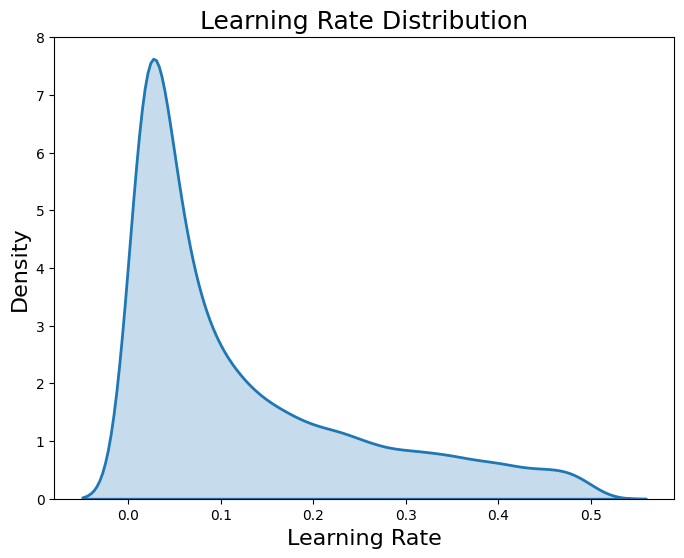

In [14]:
learning_rate_dist = []
for _ in range(10000):
    learning_rate_dist.append(sample(space)['learning_rate'])

# kdeplot
plt.figure(figsize=(8, 6))
sns.kdeplot(learning_rate_dist, linewidth=2, shade=True)
plt.title('Learning Rate Distribution', size=18)
plt.xlabel('Learning Rate', size=16)
plt.ylabel('Density', size=16)
plt.show()

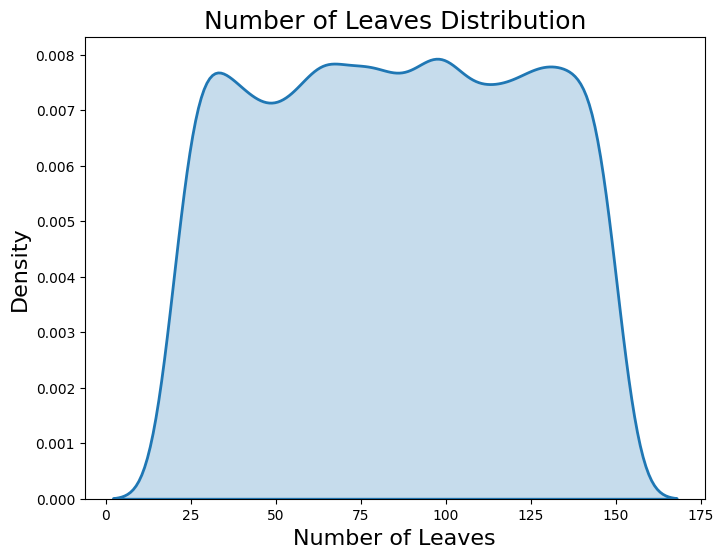

In [15]:
num_leaves_dist = []
for _ in range(10000):
    num_leaves_dist.append(sample(space)['num_leaves'])


plt.figure(figsize=(8, 6))
sns.kdeplot(num_leaves_dist, linewidth=2, fill=True)
plt.title('Number of Leaves Distribution', size=18)
plt.xlabel('Number of Leaves', size=16)
plt.ylabel('Density', size=16)
plt.show()

In [16]:
x = sample(space)

subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9910251258159898,
 'is_unbalance': True,
 'learning_rate': 0.1810659911260864,
 'min_child_samples': 315.0,
 'num_leaves': 91.0,
 'reg_alpha': 0.7968917433466272,
 'reg_lambda': 0.9112959678560587,
 'subsample_for_bin': 400.0,
 'subsample': 0.7159884714223519}

In [17]:
from hyperopt import fmin
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [18]:
def createDF(index=None):
  return pd.DataFrame(columns=['loss', 'hyperparameters', 'iteration', 'auc_score', 'l2_score', 'huber_score', 'runtime', 'time_after_iteration'],
                      index=index)

In [19]:
bayesian_results_df = createDF()


In [20]:
def objective(hyperparameters):
    global ITERATION, bayesian_results_df


    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']

    boosting_type_info = hyperparameters['boosting_type']
    subsample = boosting_type_info.get('subsample', 1.0)
    hyperparameters['boosting_type'] = boosting_type_info['boosting_type']
    hyperparameters['subsample'] = subsample

    for parameter_name in ['num_leaves', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    subsample_for_bin = int(hyperparameters.get('subsample_for_bin', 200))
    hyperparameters['subsample_for_bin'] = subsample_for_bin

    hyperparameters['verbosity'] = -1

    train_set = lgb.Dataset(data=train_features, label=train_labels, free_raw_data=False,
                            params={'subsample_for_bin': subsample_for_bin})

    start = timer()
    print(f"Starting LightGBM cross-validation for ITERATION {ITERATION} with parameters: {hyperparameters}")
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=100, nfold=N_FOLDS,
                        metrics=['auc', 'l2', 'huber'], seed=50)
    run_time = timer() - start

    auc_score = cv_results['valid auc-mean'][-1]
    l2_score = cv_results['valid l2-mean'][-1]
    huber_score = cv_results['valid huber-mean'][-1]
    loss = 1 - auc_score
    n_estimators = len(cv_results['valid auc-mean'])
    hyperparameters['n_estimators'] = n_estimators

    new_row = {
        'loss': loss,
        'hyperparameters': hyperparameters,
        'iteration': ITERATION,
        'runtime': run_time,
        'auc_score': auc_score,
        'l2_score': l2_score,
        'huber_score': huber_score,
    }
    new_row_df = pd.DataFrame([new_row])
    bayesian_results_df = pd.concat([bayesian_results_df, new_row_df], ignore_index=True)

    print(f"Iteration {ITERATION}: n_estimators = {n_estimators}, Loss = {loss:.5f}, AUC = {auc_score:.5f}, Time = {run_time:.2f}s")
    ITERATION += 1

    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [21]:
from hyperopt import fmin, tpe, atpe, hp, Trials, STATUS_OK

tpe_algorithm = tpe.suggest
trials = Trials()
from hyperopt import fmin

In [22]:
import warnings
np.warnings = warnings

In [53]:
def flatten_hyperparameters(hyperparameters):
    flat_hyperparameters = {}
    for key, value in hyperparameters.items():
        if isinstance(value, list):
            flat_hyperparameters[key] = value[0] if value else None  # Handle empty lists
        elif isinstance(value, dict):
            for subkey, subvalue in value.items():
                flat_hyperparameters[f"{key}_{subkey}"] = subvalue
        else:
            flat_hyperparameters[key] = value
    return flat_hyperparameters

def run_optimization(algo, max_evals=20, label='TPE'):
    global ITERATION, bayesian_results_df
    ITERATION = 0
    bayesian_results_df = pd.DataFrame(columns=['loss', 'hyperparameters', 'iteration', 'runtime', 'auc_score', 'l2_score', 'huber_score'])
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=algo, trials=trials, max_evals=max_evals)

    sampled_hyperparameters = []
    for trial in trials.trials:
        flat_hyperparameters = flatten_hyperparameters(trial['misc']['vals'])
        sampled_hyperparameters.append(flat_hyperparameters)

    sampled_hyperparameters_df = pd.DataFrame(sampled_hyperparameters)
    sampled_hyperparameters_df['method'] = label

    bayesian_results_df['time_after_iteration'] = bayesian_results_df['runtime'].cumsum()
    return bayesian_results_df, sampled_hyperparameters_df, trials

tpe_results, tpe_samples, tpe_trials = run_optimization(tpe.suggest, max_evals=MAX_EVALS, label='TPE')

atpe_results, atpe_samples, atpe_trials = run_optimization(atpe.suggest, max_evals=MAX_EVALS, label='ATPE')

combined_results = pd.concat([
    tpe_results.drop(columns=['hyperparameters']).assign(Method='TPE'),
    atpe_results.drop(columns=['hyperparameters']).assign(Method='ATPE')
], ignore_index=True)

combined_samples = pd.concat([
    tpe_samples,
    atpe_samples
], ignore_index=True)

summary_table = combined_results.groupby('Method').agg({
    'loss': ['mean', 'std', 'min'],
    'runtime': ['mean', 'std']
})

threshold_loss = combined_results['loss'].median()

combined_results['result_type'] = np.where(combined_results['loss'] > threshold_loss, 'bad', 'good')

combined_samples = combined_samples.reset_index(drop=True)
combined_results = combined_results.reset_index(drop=True)

combined_samples = pd.concat([combined_samples, combined_results[['Method', 'result_type']]], axis=1)

Starting LightGBM cross-validation for ITERATION 0 with parameters: {'boosting_type': 'goss', 'colsample_bytree': 0.9003953008291524, 'is_unbalance': False, 'learning_rate': 0.08793032332484305, 'min_child_samples': 495, 'num_leaves': 74, 'reg_alpha': 0.34846050339966195, 'reg_lambda': 0.992096533622405, 'subsample_for_bin': 400, 'subsample': 1.0, 'verbosity': -1}
Iteration 0: n_estimators = 100, Loss = 0.27485, AUC = 0.72515, Time = 0.69s
Starting LightGBM cross-validation for ITERATION 1 with parameters: {'boosting_type': 'dart', 'colsample_bytree': 0.9796141365989843, 'is_unbalance': False, 'learning_rate': 0.12471046640698095, 'min_child_samples': 95, 'num_leaves': 34, 'reg_alpha': 0.20567083588811208, 'reg_lambda': 0.8325359982611211, 'subsample_for_bin': 400, 'subsample': 0.6059547991482026, 'verbosity': -1}
Iteration 1: n_estimators = 100, Loss = 0.29725, AUC = 0.70275, Time = 2.92s    
Starting LightGBM cross-validation for ITERATION 2 with parameters: {'boosting_type': 'goss',

In [54]:
tpe_results

,loss,hyperparameters,iteration,runtime,auc_score,l2_score,huber_score,time_after_iteration
0,0.274851,"{'boosting_type': 'goss', 'colsample_bytree': ...",0,0.687360,0.725149,0.070537,0.035225,0.687360
1,0.297254,"{'boosting_type': 'dart', 'colsample_bytree': ...",1,2.916202,0.702746,0.071103,0.035478,3.603562
2,0.376710,"{'boosting_type': 'goss', 'colsample_bytree': ...",2,1.754707,0.623290,0.083712,0.041570,5.358269
3,0.346683,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",3,2.714946,0.653317,0.077603,0.038619,8.073215
4,0.284959,"{'boosting_type': 'dart', 'colsample_bytree': ...",4,3.278783,0.715041,0.070921,0.035399,11.351998
5,0.274036,"{'boosting_type': 'goss', 'colsample_bytree': ...",5,1.608562,0.725964,0.070377,0.035163,12.960560
6,0.278613,"{'boosting_type': 'dart', 'colsample_bytree': ...",6,2.394527,0.721387,0.070710,0.035298,15.355087
7,0.311835,"{'boosting_type': 'goss', 'colsample_bytree': ...",7,0.762462,0.688165,0.072697,0.036255,16.117550
8,0.271854,"{'boosting_type': 'goss', 'colsample_bytree': ...",8,0.688449,0.728146,0.070342,0.035134,16.805999
9,0.316152,"{'boosting_type': 'dart', 'colsample_bytree': ...",9,2.068877,0.683848,0.072553,0.036182,18.874876


# Results

In [55]:
summary_table

loss                      runtime          
            mean      std       min      mean       std
Method                                                 
ATPE    0.278574  0.01825  0.269777  1.413453  1.058611
TPE     0.287685  0.02305  0.269960  1.825501  1.259993

In [56]:
combined_samples

,boosting_type,colsample_by_tree,dart_subsample,gdbt_subsample,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,method,Method,result_type
0,2,0.900395,NaN,NaN,1,0.087930,495.0,74.0,0.348461,0.992097,400.0,TPE,TPE,good
1,1,0.979614,0.605955,NaN,1,0.124710,95.0,34.0,0.205671,0.832536,400.0,TPE,TPE,bad
2,2,0.671695,NaN,NaN,0,0.335684,80.0,93.0,0.009818,0.779123,400.0,TPE,TPE,bad
3,0,0.773878,NaN,0.995201,1,0.218896,140.0,88.0,0.137755,0.573445,400.0,TPE,TPE,bad
4,1,0.764541,0.572356,NaN,1,0.049002,115.0,42.0,0.761629,0.492173,400.0,TPE,TPE,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,0.970250,0.901236,0.579314,1,0.045460,220.0,116.0,0.851023,0.017094,400.0,ATPE,ATPE,good
96,2,0.786218,0.877996,0.580732,1,0.050745,225.0,43.0,0.860458,0.288264,400.0,ATPE,ATPE,good
97,2,0.970250,0.884518,0.580732,1,0.026775,235.0,38.0,0.860458,0.145098,400.0,ATPE,ATPE,good
98,2,0.775027,0.884797,0.568915,1,0.047852,205.0,89.0,0.818102,0.007572,400.0,ATPE,ATPE,good


## Acquisition function plots

Starting LightGBM cross-validation for ITERATION 50 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 20, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False, 'subsample': 1.0, 'verbosity': -1}
Iteration 50: n_estimators = 100, Loss = 0.30936, AUC = 0.69064, Time = 1.47s
Starting LightGBM cross-validation for ITERATION 51 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 34, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False, 'subsample': 1.0, 'verbosity': -1}
Iteration 51: n_estimators = 100, Loss = 0.32145, AUC = 0.67855, Time = 2.13s
Starting LightGBM cross-validation for ITERATION 52 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 48, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0

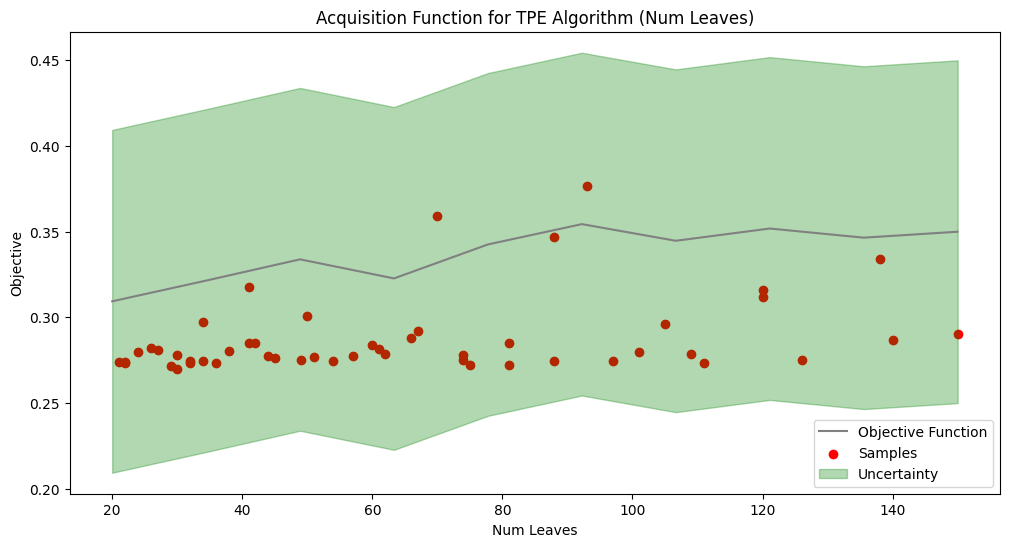

In [57]:
num_leaves = np.linspace(20, 150, 10)
ys_nl = np.array([objective({'boosting_type': {'boosting_type': 'gbdt'}, 'learning_rate': 0.1, 'num_leaves': int(nl), 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False})['loss'] for nl in num_leaves])

surrogate_means_nl = np.array([trial['result']['loss'] for trial in tpe_trials.trials])
surrogate_means_nl_vals = np.array([trial['misc']['vals']['num_leaves'][0] for trial in tpe_trials.trials])

plt.figure(figsize=(12, 6))
plt.plot(num_leaves, ys_nl, label='Objective Function', color='gray')
plt.scatter(surrogate_means_nl_vals, surrogate_means_nl, color='red', label='Samples')
plt.fill_between(num_leaves, ys_nl - 0.1, ys_nl + 0.1, alpha=0.3, color='green', label='Uncertainty')
plt.title('Acquisition Function for TPE Algorithm (Num Leaves)')
plt.xlabel('Num Leaves')
plt.ylabel('Objective')
plt.legend()
plt.show()

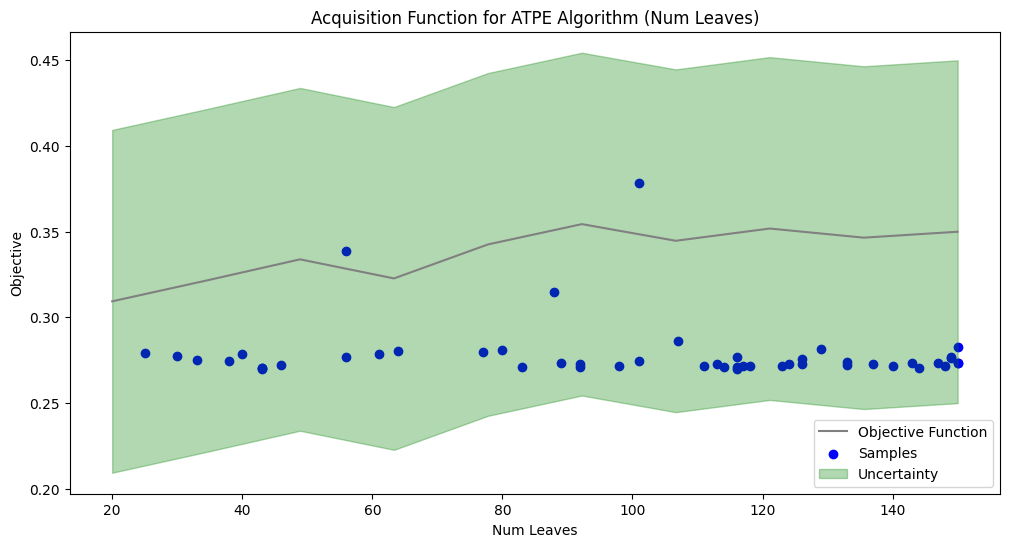

In [58]:
atpe_surrogate_means_nl = np.array([trial['result']['loss'] for trial in atpe_trials.trials])
atpe_surrogate_means_nl_vals = np.array([trial['misc']['vals']['num_leaves'][0] for trial in atpe_trials.trials])

plt.figure(figsize=(12, 6))
plt.plot(num_leaves, ys_nl, label='Objective Function', color='gray')
plt.scatter(atpe_surrogate_means_nl_vals, atpe_surrogate_means_nl, color='blue', label='Samples')
plt.fill_between(num_leaves, ys_nl - 0.1, ys_nl + 0.1, alpha=0.3, color='green', label='Uncertainty')
plt.title('Acquisition Function for ATPE Algorithm (Num Leaves)')
plt.xlabel('Num Leaves')
plt.ylabel('Objective')
plt.legend()
plt.show()


Starting LightGBM cross-validation for ITERATION 60 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 31, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False, 'subsample': 1.0, 'verbosity': -1}
Iteration 60: n_estimators = 100, Loss = 0.28277, AUC = 0.71723, Time = 2.08s
Starting LightGBM cross-validation for ITERATION 61 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01544452104946379, 'num_leaves': 31, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False, 'subsample': 1.0, 'verbosity': -1}
Iteration 61: n_estimators = 100, Loss = 0.28036, AUC = 0.71964, Time = 2.49s
Starting LightGBM cross-validation for ITERATION 62 with parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.023853323044733008, 'num_leaves': 31, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg

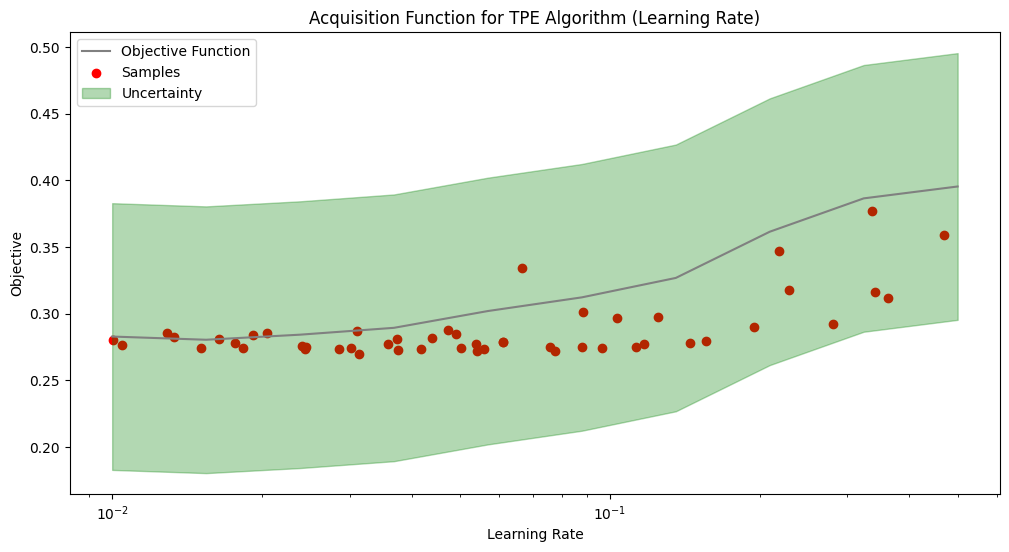

In [59]:
learning_rates = np.logspace(np.log10(0.01), np.log10(0.5), 10)
ys_lr = np.array([objective({'boosting_type': {'boosting_type': 'gbdt'}, 'learning_rate': lr, 'num_leaves': 31, 'subsample_for_bin': 200, 'min_child_samples': 20, 'reg_alpha': 0, 'reg_lambda': 0, 'colsample_bytree': 0.6, 'is_unbalance': False})['loss'] for lr in learning_rates])

surrogate_means_lr = np.array([trial['result']['loss'] for trial in tpe_trials.trials])
surrogate_means_lr_vals = np.array([trial['misc']['vals']['learning_rate'][0] for trial in tpe_trials.trials])

plt.figure(figsize=(12, 6))
plt.plot(learning_rates, ys_lr, label='Objective Function', color='gray')
plt.scatter(surrogate_means_lr_vals, surrogate_means_lr, color='red', label='Samples')
plt.fill_between(learning_rates, ys_lr - 0.1, ys_lr + 0.1, alpha=0.3, color='green', label='Uncertainty')
plt.title('Acquisition Function for TPE Algorithm (Learning Rate)')
plt.xlabel('Learning Rate')
plt.ylabel('Objective')
plt.xscale('log')
plt.legend()
plt.show()


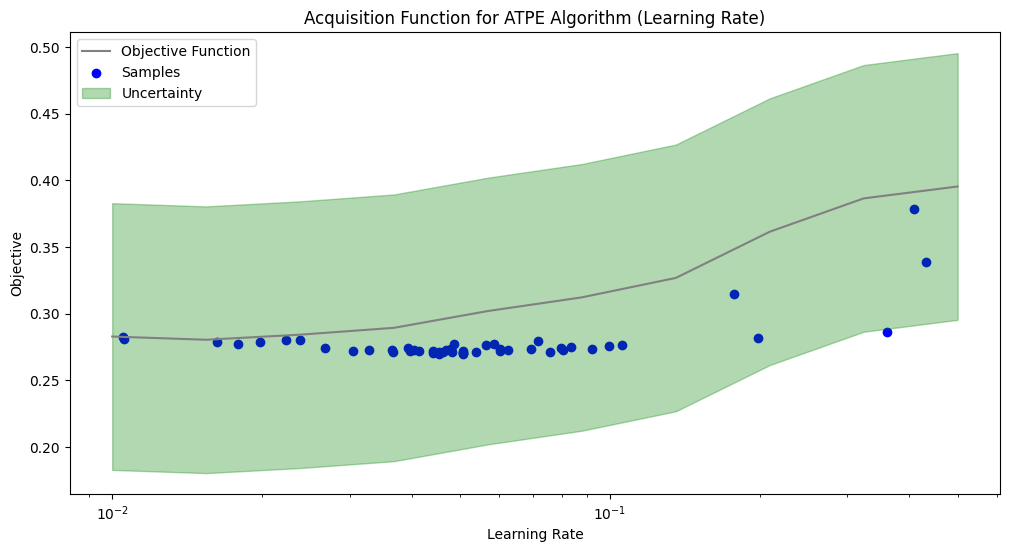

In [60]:
atpe_surrogate_means_lr = np.array([trial['result']['loss'] for trial in atpe_trials.trials])
atpe_surrogate_means_lr_vals = np.array([trial['misc']['vals']['learning_rate'][0] for trial in atpe_trials.trials])

plt.figure(figsize=(12, 6))
plt.plot(learning_rates, ys_lr, label='Objective Function', color='gray')
plt.scatter(atpe_surrogate_means_lr_vals, atpe_surrogate_means_lr, color='blue', label='Samples')
plt.fill_between(learning_rates, ys_lr - 0.1, ys_lr + 0.1, alpha=0.3, color='green', label='Uncertainty')
plt.title('Acquisition Function for ATPE Algorithm (Learning Rate)')
plt.xlabel('Learning Rate')
plt.ylabel('Objective')
plt.xscale('log')
plt.legend()
plt.show()

## Baeysian Hyperparameters

In [61]:
tpe_results

,loss,hyperparameters,iteration,runtime,auc_score,l2_score,huber_score,time_after_iteration
0,0.274851,"{'boosting_type': 'goss', 'colsample_bytree': ...",0,0.687360,0.725149,0.070537,0.035225,0.687360
1,0.297254,"{'boosting_type': 'dart', 'colsample_bytree': ...",1,2.916202,0.702746,0.071103,0.035478,3.603562
2,0.376710,"{'boosting_type': 'goss', 'colsample_bytree': ...",2,1.754707,0.623290,0.083712,0.041570,5.358269
3,0.346683,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",3,2.714946,0.653317,0.077603,0.038619,8.073215
4,0.284959,"{'boosting_type': 'dart', 'colsample_bytree': ...",4,3.278783,0.715041,0.070921,0.035399,11.351998
5,0.274036,"{'boosting_type': 'goss', 'colsample_bytree': ...",5,1.608562,0.725964,0.070377,0.035163,12.960560
6,0.278613,"{'boosting_type': 'dart', 'colsample_bytree': ...",6,2.394527,0.721387,0.070710,0.035298,15.355087
7,0.311835,"{'boosting_type': 'goss', 'colsample_bytree': ...",7,0.762462,0.688165,0.072697,0.036255,16.117550
8,0.271854,"{'boosting_type': 'goss', 'colsample_bytree': ...",8,0.688449,0.728146,0.070342,0.035134,16.805999
9,0.316152,"{'boosting_type': 'dart', 'colsample_bytree': ...",9,2.068877,0.683848,0.072553,0.036182,18.874876


In [62]:
atpe_results

,loss,hyperparameters,iteration,runtime,auc_score,l2_score,huber_score,time_after_iteration
0,0.277006,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0,1.060909,0.722994,0.070445,0.035177,1.060909
1,0.277380,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",1,2.013925,0.722620,0.070562,0.035250,3.074833
2,0.279835,"{'boosting_type': 'dart', 'colsample_bytree': ...",2,2.651480,0.720165,0.072068,0.035972,5.726313
3,0.281186,"{'boosting_type': 'dart', 'colsample_bytree': ...",3,5.585895,0.718814,0.073792,0.036829,11.312208
4,0.378251,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",4,5.767924,0.621749,0.087138,0.043233,17.080132
5,0.281724,"{'boosting_type': 'goss', 'colsample_bytree': ...",5,0.728102,0.718276,0.070730,0.035309,17.808234
6,0.314506,"{'boosting_type': 'dart', 'colsample_bytree': ...",6,4.001327,0.685494,0.071930,0.035880,21.809561
7,0.338492,"{'boosting_type': 'goss', 'colsample_bytree': ...",7,0.880229,0.661508,0.074956,0.037344,22.689790
8,0.278691,"{'boosting_type': 'dart', 'colsample_bytree': ...",8,1.848078,0.721309,0.072477,0.036178,24.537868
9,0.275006,"{'boosting_type': 'goss', 'colsample_bytree': ...",9,0.717929,0.724994,0.070377,0.035146,25.255797


In [63]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""

    new_results = results.copy()

    if isinstance(new_results['hyperparameters'].iloc[0], str):
        new_results['hyperparameters'] = new_results['hyperparameters'].apply(ast.literal_eval)

    def convert_hyperparams(hyperparams):
        for key in ['num_leaves', 'min_child_samples', 'subsample_for_bin', 'n_estimators']:
            if key in hyperparams:
                hyperparams[key] = int(hyperparams[key])
        return hyperparams

    new_results['hyperparameters'] = new_results['hyperparameters'].apply(convert_hyperparams)

    max_ind = new_results['auc_score'].idxmax()

    print('The highest cross-validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[max_ind, 'auc_score'], new_results.loc[max_ind, 'iteration']))

    new_results = new_results.sort_values('auc_score', ascending=False).reset_index(drop=True)

    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)

    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]

    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))

    hyp_df = pd.DataFrame(columns=list(hyperparameters.keys()))

    for hyp in new_results['hyperparameters']:
        hyp = convert_hyperparams(hyp)

        current_hyp_df = pd.DataFrame([hyp])
        hyp_df = pd.concat([hyp_df, current_hyp_df], ignore_index=True)

    hyp_df['iteration'] = new_results['iteration']
    hyp_df['auc_score'] = new_results['auc_score']
    hyp_df['l2_score'] = new_results['l2_score']
    hyp_df['huber_score'] = new_results['huber_score']
    hyp_df['runtime'] = new_results['runtime']
    hyp_df['time_after_iteration'] = new_results['time_after_iteration']
    hyp_df['total_runtime'] = new_results['time_after_iteration'].max()

    return hyp_df

In [64]:
bayes_hyp_tpe = evaluate(tpe_results, name = 'Bayesian')
bayes_hyp_tpe

The highest cross-validation score from Bayesian was 0.73004 found on iteration 23.
ROC AUC from Bayesian on test data = 0.74029.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,verbosity,n_estimators,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration,total_runtime
0,goss,0.720765,False,0.031313,215,30,0.383550,0.358408,400,1.000000,-1,100,23,0.730040,0.070149,0.035040,1.165363,51.791815,91.275031
1,goss,0.655364,False,0.054103,445,29,0.961536,0.534569,400,1.000000,-1,100,8,0.728146,0.070342,0.035134,0.688449,16.805999,91.275031
2,goss,0.888781,False,0.077705,270,81,0.690754,0.737980,400,1.000000,-1,100,41,0.727965,0.070194,0.035052,0.992140,77.652237,91.275031
3,goss,0.750231,False,0.037488,480,75,0.096988,0.204738,400,1.000000,-1,100,29,0.727689,0.070510,0.035222,0.697141,57.745299,91.275031
4,goss,0.724402,True,0.028504,215,22,0.446841,0.399575,400,1.000000,-1,100,22,0.726896,0.070258,0.035095,1.156145,50.626452,91.275031
5,goss,0.717011,True,0.055820,295,36,0.812832,0.513707,400,1.000000,-1,100,46,0.726642,0.070200,0.035059,1.038945,84.430200,91.275031
6,goss,0.999102,False,0.024380,260,111,0.491376,0.610797,400,1.000000,-1,100,38,0.726486,0.070384,0.035160,1.200269,72.814337,91.275031
7,goss,0.621676,False,0.041793,440,32,0.011073,0.320963,400,1.000000,-1,100,25,0.726456,0.070472,0.035201,0.718833,53.255840,91.275031
8,goss,0.649908,True,0.018292,40,21,0.559738,0.580850,400,1.000000,-1,100,5,0.725964,0.070377,0.035163,1.608562,12.960560,91.275031
9,goss,0.602375,False,0.030252,425,22,0.995762,0.391495,400,1.000000,-1,100,21,0.725864,0.070558,0.035248,0.794512,49.470307,91.275031


In [65]:
bayes_hyp_atpe = evaluate(atpe_results, name = 'Bayesian')
bayes_hyp_atpe

The highest cross-validation score from Bayesian was 0.73022 found on iteration 46.
ROC AUC from Bayesian on test data = 0.73965.


,boosting_type,colsample_bytree,is_unbalance,learning_rate,min_child_samples,num_leaves,reg_alpha,reg_lambda,subsample_for_bin,subsample,verbosity,n_estimators,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration,total_runtime
0,goss,0.786218,False,0.050745,225,43,0.860458,0.288264,400,1.000000,-1,100,46,0.730223,0.070086,0.035003,0.985751,67.326105,70.67263
1,goss,0.782351,False,0.045460,320,116,0.919824,0.931519,400,1.000000,-1,100,39,0.730150,0.070192,0.035059,0.893621,58.133790,70.67263
2,goss,0.970250,False,0.050745,390,144,0.891768,0.963535,400,1.000000,-1,100,32,0.729780,0.070293,0.035108,1.571698,50.163041,70.67263
3,goss,0.926208,False,0.044137,320,43,0.993959,0.450771,400,1.000000,-1,100,31,0.729623,0.070188,0.035056,1.108566,48.591343,70.67263
4,goss,0.970250,False,0.050745,345,43,0.993485,0.288264,400,1.000000,-1,100,24,0.729444,0.070203,0.035062,0.879082,40.440465,70.67263
5,goss,0.808521,False,0.048241,330,114,0.924709,0.159399,400,1.000000,-1,100,44,0.729169,0.070212,0.035068,1.164973,64.948078,70.67263
6,goss,0.799636,False,0.046160,230,92,0.917593,0.052515,400,1.000000,-1,100,42,0.729141,0.070108,0.035015,1.442391,62.543446,70.67263
7,goss,0.970250,False,0.053825,230,83,0.919824,0.104034,400,1.000000,-1,100,41,0.729077,0.070215,0.035067,1.768112,61.101055,70.67263
8,goss,0.970250,False,0.045460,220,116,0.851023,0.017094,400,1.000000,-1,100,45,0.728889,0.070228,0.035074,1.392276,66.340354,70.67263
9,goss,0.921709,False,0.036723,315,118,0.873622,0.109900,400,1.000000,-1,100,34,0.728541,0.070240,0.035084,0.936250,52.657476,70.67263


In [66]:
import csv

## Manual Search

In [67]:
small_param_grid = {
    'boosting_type': ['gbdt'],
    'num_leaves': [20, 100],
    'learning_rate': [0.005, 0.05],
    'subsample_for_bin': [20000, 200000],
    'min_child_samples': [20, 300],
    'reg_alpha': [0.0, 1.0],
    'reg_lambda': [0.0, 1.0],
    'colsample_bytree': [0.6, 1.0],
    'subsample': [0.5, 1.0],
    'is_unbalance': [True, False]
}

grid_size = (
    len(small_param_grid['boosting_type']) *
    len(small_param_grid['num_leaves']) *
    len(small_param_grid['learning_rate']) *
    len(small_param_grid['subsample_for_bin']) *
    len(small_param_grid['min_child_samples']) *
    len(small_param_grid['reg_alpha']) *
    len(small_param_grid['reg_lambda']) *
    len(small_param_grid['colsample_bytree']) *
    len(small_param_grid['subsample']) *
    len(small_param_grid['is_unbalance'])
)

grid_size, small_param_grid

(512,
 {'boosting_type': ['gbdt'],
  'num_leaves': [20, 100],
  'learning_rate': [0.005, 0.05],
  'subsample_for_bin': [20000, 200000],
  'min_child_samples': [20, 300],
  'reg_alpha': [0.0, 1.0],
  'reg_lambda': [0.0, 1.0],
  'colsample_bytree': [0.6, 1.0],
  'subsample': [0.5, 1.0],
  'is_unbalance': [True, False]})

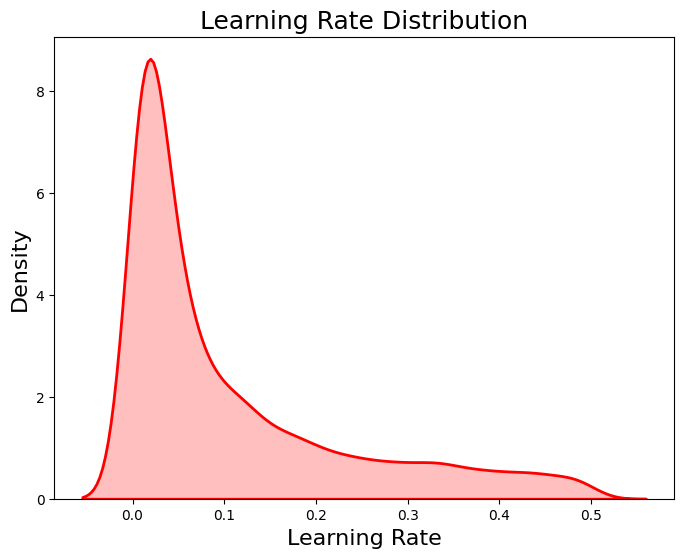

In [68]:
import random

learning_rate_dist = []

for _ in range(10000):
    learning_rate_dist.append(random.choice(param_grid['learning_rate']))

plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True)
plt.title('Learning Rate Distribution', size = 18)
plt.xlabel('Learning Rate', size = 16)
plt.ylabel('Density', size = 16)
plt.show()

In [69]:
import random

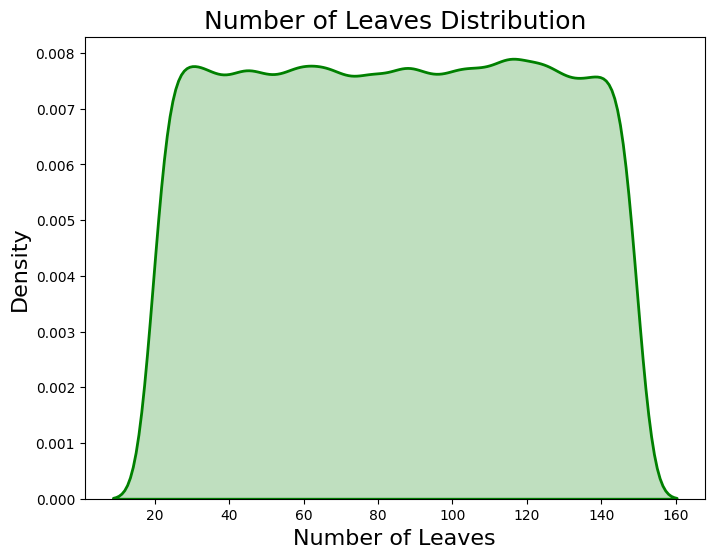

In [70]:
num_leaves_dist = []

# Draw 10000 samples from the num_leaves domain
for _ in range(100000):
    num_leaves_dist.append(random.choice(param_grid['num_leaves']))

plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, color = 'green', linewidth = 2, shade = True)
plt.title('Number of Leaves Distribution', size = 18)
plt.xlabel('Number of Leaves', size = 16)
plt.ylabel('Density', size = 16)
plt.show()

In [71]:
# Dataframes for random and grid search
random_results = createDF(index=list(range(MAX_EVALS)))

grid_results = createDF(index=list(range(MAX_EVALS)))

In [72]:
import itertools
import pandas as pd

def grid_search(param_grid, max_evals):
    """Grid search algorithm (with limit on max evals)
       Stores result of search in a DataFrame."""

    results = pd.DataFrame(columns=['l2_score', 'huber_score', 'auc_score', 'params', 'iteration'])

    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())

    i = 0

    for v in itertools.product(*values):
      start = timer()

      parameters = dict(zip(keys, v))

      if parameters['boosting_type'] == 'goss':
          parameters['subsample'] = 1.0

      eval_results = objective_manual(parameters, i)

      run_time = timer() - start

      new_row = pd.DataFrame([{
          'l2_score': eval_results[0],
          'huber_score': eval_results[1],
          'auc_score': eval_results[2],
          'hyperparameters': parameters,
          'iteration': i,
          'runtime': run_time
      }])

      results = pd.concat([results, new_row], ignore_index=True)

      i += 1

      if i >= max_evals:
          break

    results['time_after_iteration'] = results['runtime'].cumsum()

    results.sort_values('auc_score', ascending=False, inplace=True)
    results.reset_index(drop=True, inplace=True)

    return results

In [73]:
N_FOLDS = 5

In [74]:

def objective_manual(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']

    # Adjust hyperparameters that need to be integers
    hyperparameters['num_leaves'] = int(hyperparameters.get('num_leaves', 31))
    hyperparameters['min_child_samples'] = int(hyperparameters.get('min_child_samples', 20))
    subsample_for_bin = int(hyperparameters.get('subsample_for_bin', 200))
    hyperparameters['subsample_for_bin'] = subsample_for_bin

    # Recreate the dataset with the current hyperparameters
    train_set = lgb.Dataset(data=train_features, label=train_labels, free_raw_data=False,
                            params={'subsample_for_bin': subsample_for_bin})

    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=3, nfold=N_FOLDS, metrics=['auc', 'l2', 'huber'], seed=42)

    auc_score = cv_results['valid auc-mean'][-1]
    l2_score = cv_results['valid l2-mean'][-1]
    huber_score = cv_results['valid huber-mean'][-1]
    estimators = len(cv_results['valid auc-mean'])
    hyperparameters['n_estimators'] = estimators

    return [huber_score, l2_score, auc_score, hyperparameters, iteration]

In [75]:
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [76]:
def random_search(param_grid, max_evals):
    """Random search for hyperparameter optimization.
       Stores result of search in a DataFrame."""

    results = pd.DataFrame(columns=['l2_score', 'huber_score', 'auc_score', 'params', 'iteration'])

    for i in range(max_evals):
        start = timer()
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        random_params['subsample'] = 1.0 if random_params['boosting_type'] == 'goss' else random_params['subsample']

        eval_results = objective_manual(random_params, i)

        new_row = pd.DataFrame([{
            'l2_score': eval_results[0],
            'huber_score': eval_results[1],
            'auc_score': eval_results[2],
            'hyperparameters': random_params,
            'iteration': i,
            'runtime': (timer() - start)
        }])

        results = pd.concat([results, new_row], ignore_index=True)

    results['time_after_iteration'] = results['runtime'].cumsum()

    results.sort_values('auc_score', ascending=False, inplace=True)
    results.reset_index(drop=True, inplace=True)

    return results

In [44]:
import csv


In [89]:
grid_results = grid_search(small_param_grid, MAX_EVALS)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 93
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9993
[LightGBM] [Info] Number of data poi

In [91]:
grid_results

,l2_score,huber_score,auc_score,params,iteration,hyperparameters,runtime,time_after_iteration
0,0.037456,0.074938,0.702545,NaN,49,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.153574,6.577457
1,0.037456,0.074938,0.702545,NaN,48,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.149372,6.423883
2,0.037455,0.074935,0.700966,NaN,35,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.115451,4.641142
3,0.037455,0.074935,0.700966,NaN,34,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.111542,4.525690
4,0.037455,0.074935,0.700966,NaN,33,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.113999,4.414148
5,0.037455,0.074935,0.700966,NaN,32,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.117693,4.300150
6,0.037455,0.074936,0.700885,NaN,43,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.137399,5.692967
7,0.037455,0.074936,0.700885,NaN,42,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.184798,5.555568
8,0.037455,0.074936,0.700885,NaN,41,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.128435,5.370770
9,0.037455,0.074936,0.700885,NaN,40,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0.127080,5.242335


In [90]:
random_results = random_search(param_grid,MAX_EVALS)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9971
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 82
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9971
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 82
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9971
[LightGBM] [Info] Number of data poi

In [48]:
random_results

,l2_score,huber_score,auc_score,params,iteration,hyperparameters,runtime,time_after_iteration
0,0.037358,0.074739,0.708033,NaN,44,"{'boosting_type': 'dart', 'num_leaves': 20, 'l...",0.112762,6.877468
1,0.035790,0.071635,0.705749,NaN,22,"{'boosting_type': 'goss', 'num_leaves': 114, '...",0.105738,3.622984
2,0.035641,0.071358,0.705147,NaN,9,"{'boosting_type': 'gbdt', 'num_leaves': 70, 'l...",0.110004,1.443744
3,0.035784,0.071619,0.704276,NaN,14,"{'boosting_type': 'goss', 'num_leaves': 129, '...",0.135732,2.162706
4,0.036137,0.072312,0.703559,NaN,7,"{'boosting_type': 'dart', 'num_leaves': 127, '...",0.114075,1.209835
5,0.035777,0.071610,0.702818,NaN,36,"{'boosting_type': 'goss', 'num_leaves': 144, '...",0.145311,5.770872
6,0.036591,0.073207,0.701466,NaN,1,"{'boosting_type': 'goss', 'num_leaves': 82, 'l...",0.156453,0.280019
7,0.037406,0.074837,0.700971,NaN,0,"{'boosting_type': 'gbdt', 'num_leaves': 85, 'l...",0.123565,0.123565
8,0.036284,0.072601,0.700213,NaN,8,"{'boosting_type': 'goss', 'num_leaves': 79, 'l...",0.123904,1.333740
9,0.036495,0.073017,0.698406,NaN,45,"{'boosting_type': 'goss', 'num_leaves': 74, 'l...",0.127657,7.005125


## Hyperband

In [78]:
import keras_tuner as kt
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from timeit import default_timer as timer

ITERATION = 0
hyperband_results_df = createDF()

N_FOLDS = 5

def hyp_objective(hyperparameters):
    global ITERATION, hyperband_results_df

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']

    boosting_type_info = hyperparameters['boosting_type']
    subsample = boosting_type_info.get('subsample', 1.0)
    hyperparameters['boosting_type'] = boosting_type_info['boosting_type']
    hyperparameters['subsample'] = subsample

    for parameter_name in ['num_leaves', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    subsample_for_bin = int(hyperparameters.get('subsample_for_bin', 200))
    hyperparameters['subsample_for_bin'] = subsample_for_bin

    hyperparameters['verbosity'] = -1

    train_set = lgb.Dataset(data=train_features, label=train_labels, free_raw_data=False,
                            params={'subsample_for_bin': subsample_for_bin})

    start = timer()
    print(f"Starting LightGBM cross-validation for ITERATION {ITERATION} with parameters: {hyperparameters}")
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round=100, nfold=N_FOLDS,
                        metrics=['auc', 'l2', 'huber'], seed=50)
    run_time = timer() - start

    auc_score = cv_results['valid auc-mean'][-1]
    l2_score = cv_results['valid l2-mean'][-1]
    huber_score = cv_results['valid huber-mean'][-1]
    loss = 1 - auc_score
    n_estimators = len(cv_results['valid auc-mean'])
    hyperparameters['n_estimators'] = n_estimators

    new_row = {
        'loss': loss,
        'hyperparameters': hyperparameters,
        'iteration': ITERATION,
        'runtime': run_time,
        'auc_score': auc_score,
        'l2_score': l2_score,
        'huber_score': huber_score,
    }
    new_row_df = pd.DataFrame([new_row])
    hyperband_results_df = pd.concat([hyperband_results_df, new_row_df], ignore_index=True)

    print(f"Iteration {ITERATION}: n_estimators = {n_estimators}, Loss = {loss:.5f}, AUC = {auc_score:.5f}, Time = {run_time:.2f}s")

    ITERATION += 1

    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': 'ok'}

class LGBHyperModel(kt.HyperModel):
    def build(self, hp):
        params = {
            'boosting_type': {
                'boosting_type': hp.Choice('boosting_type', ['gbdt', 'dart', 'goss']),
                'subsample': hp.Float('subsample', min_value=0.5, max_value=1.0, step=0.1)
            },
            'num_leaves': hp.Int('num_leaves', min_value=20, max_value=150, step=1),
            'learning_rate': hp.Float('learning_rate', min_value=0.01, max_value=0.5, sampling='log'),
            'subsample_for_bin': hp.Int('subsample_for_bin', min_value=200, max_value=300, step=50),
            'min_child_samples': hp.Int('min_child_samples', min_value=20, max_value=500, step=5),
            'reg_alpha': hp.Float('reg_alpha', min_value=0.0, max_value=1.0),
            'reg_lambda': hp.Float('reg_lambda', min_value=0.0, max_value=1.0),
            'colsample_bytree': hp.Float('colsample_bytree', min_value=0.6, max_value=1.0),
            'is_unbalance': hp.Choice('is_unbalance', ["true", "false"]),
            'objective': 'binary'
        }

        result = hyp_objective(params)

        model = keras.Sequential()
        model.add(layers.Dense(1, input_shape=(1,), activation='linear'))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.accuracy = result['loss']

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.accuracy

class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        model = self.hypermodel.build(hp)
        val_accuracy = self.hypermodel.fit(hp, model, *args, **kwargs)
        self.oracle.update_trial(trial.trial_id, {'val_accuracy': val_accuracy})

    def save_model(self, trial_id, model, step=0):
        pass

    def load_model(self, trial):
        pass

tuner = MyTuner(
    LGBHyperModel(),
    objective=kt.Objective('val_accuracy', 'min'),
    max_epochs=50,
    executions_per_trial=3,
    directory='hyperband',
    project_name='LGBM_hyperband_50'
)

tuner.search_space_summary()

start = timer()
tuner.search(train_features, train_labels, validation_split=0.1)
hyperband_results_df['time_after_iteration'] = hyperband_results_df['runtime'].cumsum()

tuner.results_summary()

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal parameters are:
boosting_type: {best_hps.get('boosting_type')}
num_leaves: {best_hps.get('num_leaves')}
learning_rate: {best_hps.get('learning_rate')}
subsample_for_bin: {best_hps.get('subsample_for_bin')}
min_child_samples: {best_hps.get('min_child_samples')}
reg_alpha: {best_hps.get('reg_alpha')}
reg_lambda: {best_hps.get('reg_lambda')}
colsample_bytree: {best_hps.get('colsample_bytree')}
is_unbalance: {best_hps.get('is_unbalance')}
""")
hyperband_results_df

Trial 90 Complete [00h 00m 01s]
val_accuracy: 0.2875581562960764

Best val_accuracy So Far: 0.27273355683780376
Total elapsed time: 00h 03m 05s
Results summary
Results in hyperband/LGBM_hyperband_50
Showing 10 best trials
Objective(name="val_accuracy", direction="min")

Trial 0025 summary
Hyperparameters:
boosting_type: goss
subsample: 0.8
num_leaves: 46
learning_rate: 0.03286725462835006
subsample_for_bin: 300
min_child_samples: 230
reg_alpha: 0.6724358553925761
reg_lambda: 0.0968474767806411
colsample_bytree: 0.7703146213359429
is_unbalance: false
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.27273355683780376

Trial 0034 summary
Hyperparameters:
boosting_type: goss
subsample: 0.8
num_leaves: 46
learning_rate: 0.03286725462835006
subsample_for_bin: 300
min_child_samples: 230
reg_alpha: 0.6724358553925761
reg_lambda: 0.0968474767806411
colsample_bytree: 0.7703146213359429
is_unbalance: false
tuner/epochs: 6
tuner/initial_epoch: 2
tuner/bracket: 3
tune

,loss,hyperparameters,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration
0,0.287078,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0,0.712922,0.113696,0.056848,1.998926,1.998926
1,0.278359,"{'boosting_type': 'gbdt', 'num_leaves': 130, '...",1,0.721641,0.174918,0.087459,1.512746,3.511672
2,0.291056,"{'boosting_type': 'goss', 'num_leaves': 21, 'l...",2,0.708944,0.181321,0.090657,0.833302,4.344974
3,0.275421,"{'boosting_type': 'goss', 'num_leaves': 125, '...",3,0.724579,0.070212,0.035071,1.908076,6.253050
4,0.297225,"{'boosting_type': 'goss', 'num_leaves': 102, '...",4,0.702775,0.072007,0.035942,0.756010,7.009060
...,...,...,...,...,...,...,...,...
86,0.298972,"{'boosting_type': 'dart', 'num_leaves': 61, 'l...",86,0.701028,0.125958,0.062977,4.588068,179.737588
87,0.286139,"{'boosting_type': 'dart', 'num_leaves': 120, '...",87,0.713861,0.135433,0.067717,2.301659,182.039247
88,0.320170,"{'boosting_type': 'dart', 'num_leaves': 57, 'l...",88,0.679830,0.074435,0.037124,1.892952,183.932199
89,0.279278,"{'boosting_type': 'goss', 'num_leaves': 74, 'l...",89,0.720722,0.070666,0.035286,0.884626,184.816825


In [79]:
hyperband_results_df

,loss,hyperparameters,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration
0,0.287078,"{'boosting_type': 'gbdt', 'num_leaves': 20, 'l...",0,0.712922,0.113696,0.056848,1.998926,1.998926
1,0.278359,"{'boosting_type': 'gbdt', 'num_leaves': 130, '...",1,0.721641,0.174918,0.087459,1.512746,3.511672
2,0.291056,"{'boosting_type': 'goss', 'num_leaves': 21, 'l...",2,0.708944,0.181321,0.090657,0.833302,4.344974
3,0.275421,"{'boosting_type': 'goss', 'num_leaves': 125, '...",3,0.724579,0.070212,0.035071,1.908076,6.253050
4,0.297225,"{'boosting_type': 'goss', 'num_leaves': 102, '...",4,0.702775,0.072007,0.035942,0.756010,7.009060
...,...,...,...,...,...,...,...,...
86,0.298972,"{'boosting_type': 'dart', 'num_leaves': 61, 'l...",86,0.701028,0.125958,0.062977,4.588068,179.737588
87,0.286139,"{'boosting_type': 'dart', 'num_leaves': 120, '...",87,0.713861,0.135433,0.067717,2.301659,182.039247
88,0.320170,"{'boosting_type': 'dart', 'num_leaves': 57, 'l...",88,0.679830,0.074435,0.037124,1.892952,183.932199
89,0.279278,"{'boosting_type': 'goss', 'num_leaves': 74, 'l...",89,0.720722,0.070666,0.035286,0.884626,184.816825


## Evaluation

In [92]:
hb_hyp = evaluate(hyperband_results_df[hyperband_results_df['iteration'] < MAX_EVALS], name = 'hyperband')

The highest cross-validation score from hyperband was 0.72727 found on iteration 26.
ROC AUC from hyperband on test data = 0.74065.


In [93]:
hb_hyp

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,is_unbalance,objective,subsample,verbosity,n_estimators,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration,total_runtime
0,goss,46,0.032867,300,230,0.672436,0.096847,0.770315,false,binary,0.8,-1,100,47,0.727266,0.070058,0.034994,1.234568,94.273625,96.928601
1,goss,46,0.032867,300,230,0.672436,0.096847,0.770315,false,binary,0.8,-1,100,35,0.727266,0.070058,0.034994,1.597048,74.339944,96.928601
2,goss,46,0.032867,300,230,0.672436,0.096847,0.770315,false,binary,0.8,-1,100,26,0.727266,0.070058,0.034994,1.448493,58.781143,96.928601
3,goss,35,0.045471,300,335,0.579452,0.028831,0.970628,false,binary,0.8,-1,100,48,0.727072,0.070077,0.035000,0.883737,95.157362,96.928601
4,goss,35,0.045471,300,335,0.579452,0.028831,0.970628,false,binary,0.8,-1,100,5,0.727072,0.070077,0.035000,0.901411,7.910470,96.928601
5,goss,35,0.045471,300,335,0.579452,0.028831,0.970628,false,binary,0.8,-1,100,36,0.727072,0.070077,0.035000,1.076123,75.416067,96.928601
6,goss,125,0.031243,250,115,0.596845,0.688683,0.631944,false,binary,0.6,-1,100,49,0.724579,0.070212,0.035071,1.771239,96.928601,96.928601
7,goss,125,0.031243,250,115,0.596845,0.688683,0.631944,false,binary,0.6,-1,100,3,0.724579,0.070212,0.035071,1.908076,6.253050,96.928601
8,goss,125,0.031243,250,115,0.596845,0.688683,0.631944,false,binary,0.6,-1,100,37,0.724579,0.070212,0.035071,2.465656,77.881722,96.928601
9,dart,115,0.039669,200,495,0.094901,0.023303,0.870053,false,binary,0.8,-1,100,8,0.722088,0.073927,0.036962,1.570350,12.818221,96.928601


In [94]:
grid_hyp = evaluate(grid_results, name = 'grid search')

The highest cross-validation score from grid search was 0.70255 found on iteration 49.
[LightGBM] [Info] Number of positive: 817, number of negative: 9183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9975
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081700 -> initscore=-2.419470
[LightGBM] [Info] Start training from score -2.419470
ROC AUC from grid search on test data = 0.70128.


In [95]:
grid_hyp

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,is_unbalance,n_estimators,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration,total_runtime
0,gbdt,20,0.005,20000,300,1.0,0.0,0.6,0.5,False,3,49,0.702545,0.037456,0.074938,0.153574,6.577457,6.577457
1,gbdt,20,0.005,20000,300,1.0,0.0,0.6,0.5,True,3,48,0.702545,0.037456,0.074938,0.149372,6.423883,6.577457
2,gbdt,20,0.005,20000,300,0.0,0.0,0.6,1.0,False,3,35,0.700966,0.037455,0.074935,0.115451,4.641142,6.577457
3,gbdt,20,0.005,20000,300,0.0,0.0,0.6,1.0,True,3,34,0.700966,0.037455,0.074935,0.111542,4.525690,6.577457
4,gbdt,20,0.005,20000,300,0.0,0.0,0.6,0.5,False,3,33,0.700966,0.037455,0.074935,0.113999,4.414148,6.577457
5,gbdt,20,0.005,20000,300,0.0,0.0,0.6,0.5,True,3,32,0.700966,0.037455,0.074935,0.117693,4.300150,6.577457
6,gbdt,20,0.005,20000,300,0.0,1.0,0.6,1.0,False,3,43,0.700885,0.037455,0.074936,0.137399,5.692967,6.577457
7,gbdt,20,0.005,20000,300,0.0,1.0,0.6,1.0,True,3,42,0.700885,0.037455,0.074936,0.184798,5.555568,6.577457
8,gbdt,20,0.005,20000,300,0.0,1.0,0.6,0.5,False,3,41,0.700885,0.037455,0.074936,0.128435,5.370770,6.577457
9,gbdt,20,0.005,20000,300,0.0,1.0,0.6,0.5,True,3,40,0.700885,0.037455,0.074936,0.127080,5.242335,6.577457


In [96]:
random_hyp = evaluate(random_results, name = 'random search')

The highest cross-validation score from random search was 0.70845 found on iteration 5.
[LightGBM] [Info] Number of positive: 817, number of negative: 9183
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9975
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081700 -> initscore=-2.419470
[LightGBM] [Info] Start training from score -2.419470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC from random search on test data = 0.71819.


In [97]:
random_hyp

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,is_unbalance,n_estimators,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration,total_runtime
0,dart,93,0.013785,20000,370,0.387755,0.714286,0.688889,0.737374,False,3,5,0.708445,0.037375,0.074772,0.138576,1.207017,7.56784
1,dart,104,0.449701,40000,370,0.326531,0.673469,0.822222,0.843434,True,3,47,0.705315,0.035687,0.071446,0.118693,7.360613,7.56784
2,goss,49,0.015469,240000,355,0.857143,0.530612,0.600000,1.000000,True,3,27,0.705005,0.037372,0.074767,0.109002,4.257618,7.56784
3,goss,42,0.070164,60000,355,0.081633,0.183673,0.600000,1.000000,False,3,19,0.704866,0.036964,0.073948,0.121332,3.260439,7.56784
4,goss,87,0.443525,120000,310,0.816327,0.346939,0.600000,1.000000,False,3,15,0.704105,0.035793,0.071643,0.113638,2.754707,7.56784
5,dart,80,0.199789,220000,370,0.877551,0.306122,0.866667,0.873737,True,3,26,0.703175,0.036137,0.072312,0.105677,4.148616,7.56784
6,goss,86,0.209214,160000,485,0.204082,0.142857,0.777778,1.000000,False,3,3,0.703165,0.036257,0.072547,0.195941,0.756068,7.56784
7,goss,65,0.379184,100000,180,0.387755,0.061224,0.600000,1.000000,True,3,38,0.701604,0.035736,0.071531,0.124655,5.907418,7.56784
8,dart,43,0.220097,60000,490,0.224490,0.489796,0.955556,0.691919,True,3,17,0.701107,0.036118,0.072277,0.097811,2.995104,7.56784
9,dart,146,0.005458,240000,495,0.448980,0.551020,0.644444,0.621212,True,3,0,0.700354,0.037455,0.074935,0.167611,0.167611,7.56784


In [98]:
import pandas as pd

random_hyp['search'] = 'random'
grid_hyp['search'] = 'grid'
bayes_hyp_tpe['search'] = 'TPE'
bayes_hyp_atpe['search'] = 'aTPE'
hb_hyp['search'] = 'hyperband'
hyp = pd.concat([random_hyp, grid_hyp,bayes_hyp_tpe,bayes_hyp_atpe, hb_hyp], ignore_index=True)
sorted_hyp = hyp.sort_values(by='auc_score', ascending=False)

sorted_hyp.reset_index(drop=True, inplace=True)

In [ ]:
len(hb_hyp[hb_hyp["search"] == "hyperband"]["iteration"])

10

In [ ]:
sorted_hyp[["l2_score", "huber_score", "auc_score", "search", "total_runtime", "iteration"]]

,l2_score,huber_score,auc_score,search,total_runtime,iteration
0,0.070451,0.035183,0.728608,aTPE,35.887615,49
1,0.070341,0.035137,0.728503,TPE,58.425895,40
2,0.070429,0.035175,0.728142,TPE,58.425895,24
3,0.070519,0.035220,0.728125,aTPE,35.887615,26
4,0.070393,0.035155,0.728089,aTPE,35.887615,31
...,...,...,...,...,...,...
245,0.037442,0.074909,0.649156,grid,6.629815,4
246,0.037442,0.074909,0.649156,grid,6.629815,6
247,0.037442,0.074909,0.649156,grid,6.629815,5
248,0.083904,0.041651,0.624912,TPE,58.425895,0


In [ ]:
sorted_hyp.head(10)

In [ ]:
hyp[hyp['search'] == 'hyperband']

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_child_samples,reg_alpha,reg_lambda,colsample_bytree,subsample,is_unbalance,...,iteration,auc_score,l2_score,huber_score,runtime,time_after_iteration,total_runtime,search,verbosity,objective
200,goss,71,0.050791,250,435,0.153897,0.315230,0.818564,0.9,false,...,30,0.727794,0.070075,0.035000,1.668534,121.978756,173.153941,hyperband,-1,binary
201,goss,71,0.050791,250,435,0.153897,0.315230,0.818564,0.9,false,...,47,0.727794,0.070075,0.035000,1.442102,165.806068,173.153941,hyperband,-1,binary
202,goss,71,0.050791,250,435,0.153897,0.315230,0.818564,0.9,false,...,35,0.727794,0.070075,0.035000,1.412499,134.941938,173.153941,hyperband,-1,binary
203,goss,62,0.028898,300,395,0.151643,0.835864,0.644293,0.8,false,...,15,0.725193,0.070224,0.035081,1.655179,61.060307,173.153941,hyperband,-1,binary
204,goss,62,0.028898,300,395,0.151643,0.835864,0.644293,0.8,false,...,48,0.725193,0.070224,0.035081,1.515554,167.321622,173.153941,hyperband,-1,binary
205,goss,62,0.028898,300,395,0.151643,0.835864,0.644293,0.8,false,...,36,0.725193,0.070224,0.035081,1.534657,136.476595,173.153941,hyperband,-1,binary
206,dart,33,0.086130,250,355,0.865157,0.194297,0.618584,0.5,false,...,27,0.724724,0.071060,0.035516,6.873960,115.874899,173.153941,hyperband,-1,binary
207,dart,33,0.086130,250,355,0.865157,0.194297,0.618584,0.5,false,...,37,0.724724,0.071060,0.035516,2.829343,139.305938,173.153941,hyperband,-1,binary
208,dart,33,0.086130,250,355,0.865157,0.194297,0.618584,0.5,false,...,49,0.724724,0.071060,0.035516,5.832319,173.153941,173.153941,hyperband,-1,binary
209,gbdt,118,0.025476,250,450,0.994751,0.684176,0.729577,0.6,true,...,1,0.723494,0.171975,0.085987,3.053215,5.626283,173.153941,hyperband,-1,binary


### Statistics

In [102]:
metric_cols = ['auc_score', 'l2_score', 'huber_score', 'total_runtime', 'iteration', 'time_after_iteration', 'search']
sliced_hyp = hyp[metric_cols]

def get_extreme_values(df, group_col, target_col, extreme='max'):
    if extreme == 'max':
        indices = df.groupby(group_col)[target_col].idxmax()
    elif extreme == 'min':
        indices = df.groupby(group_col)[target_col].idxmin()
    else:
        raise ValueError("Parameter `extreme` must be either 'max' or 'min'")
    return df.loc[indices, [group_col, target_col]]

max_auc_df = get_extreme_values(sliced_hyp, 'search', 'auc_score', 'max')
min_l2_df = get_extreme_values(sliced_hyp, 'search', 'l2_score', 'min')
min_huber_df = get_extreme_values(sliced_hyp, 'search', 'huber_score', 'min')

print("Best Search Method for Maximum AUC Score:")
for index, row in max_auc_df.iterrows():
    print(f"Search Method: {row['search']}, Maximum AUC Score: {row['auc_score']:.5f}")

print("\nBest Search Method for Minimum L2 Score:")
for index, row in min_l2_df.iterrows():
    print(f"Search Method: {row['search']}, Minimum L2 Score: {row['l2_score']:.5f}")

print("\nBest Search Method for Minimum Huber Score:")
for index, row in min_huber_df.iterrows():
    print(f"Search Method: {row['search']}, Minimum Huber Score: {row['huber_score']:.5f}")

mean_scores = sliced_hyp.groupby('search').agg({
    'auc_score': 'mean',
    'l2_score': 'mean',
    'huber_score': 'mean',
    'total_runtime': 'mean',
    'iteration': 'count'
}).reset_index()

print("\nMean Scores and Total Iteration Counts for Each Search Method:")
for index, row in mean_scores.iterrows():
    print(f"Search Method: {row['search']}, AUC Score: {row['auc_score']:.5f}, L2 Score: {row['l2_score']:.5f}, Huber Score: {row['huber_score']:.5f}, Total Runtime: {row['total_runtime']:.5f}, Iterations: {row['iteration']}")

mean_scores_per_iter_time = sliced_hyp.groupby('search').agg({
    'auc_score': 'mean',
    'l2_score': 'mean',
    'huber_score': 'mean',
    'time_after_iteration': 'mean'
}).reset_index()

print("\nMean Scores per Cumulative Iteration Time for Each Search Method:")
for index, row in mean_scores_per_iter_time.iterrows():
    print(f"Search Method: {row['search']}, AUC Score: {row['auc_score']:.5f}, L2 Score: {row['l2_score']:.5f}, Huber Score: {row['huber_score']:.5f}, Cumulative Iteration Time: {row['time_after_iteration']:.5f}")

best_auc_search = mean_scores.loc[mean_scores['auc_score'].idxmax()]
best_l2_search = mean_scores.loc[mean_scores['l2_score'].idxmin()]
best_huber_search = mean_scores.loc[mean_scores['huber_score'].idxmin()]

print("\nBest Search Method Based on Average AUC Score:")
print(f"Search Method: {best_auc_search['search']}, Average AUC Score: {best_auc_search['auc_score']:.5f}")

print("\nBest Search Method Based on Average L2 Score:")
print(f"Search Method: {best_l2_search['search']}, Average L2 Score: {best_l2_search['l2_score']:.5f}")

print("\nBest Search Method Based on Average Huber Score:")
print(f"Search Method: {best_huber_search['search']}, Average Huber Score: {best_huber_search['huber_score']:.5f}")

mean_scores['auc_per_time'] = mean_scores['auc_score'] / mean_scores['total_runtime']
mean_scores['l2_per_time'] = mean_scores['l2_score'] / mean_scores['total_runtime']
mean_scores['huber_per_time'] = mean_scores['huber_score'] / mean_scores['total_runtime']

best_auc_time_search = mean_scores.loc[mean_scores['auc_per_time'].idxmax()]
best_l2_time_search = mean_scores.loc[mean_scores['l2_per_time'].idxmin()]
best_huber_time_search = mean_scores.loc[mean_scores['huber_per_time'].idxmin()]

print("\nBest Search Method Based on AUC Score per Unit Time:")
print(f"Search Method: {best_auc_time_search['search']}, AUC Score per Time: {best_auc_time_search['auc_per_time']:.5f}")

print("\nBest Search Method Based on L2 Score per Unit Time:")
print(f"Search Method: {best_l2_time_search['search']}, L2 Score per Time: {best_l2_time_search['l2_per_time']:.5f}")

print("\nBest Search Method Based on Huber Score per Unit Time:")
print(f"Search Method: {best_huber_time_search['search']}, Huber Score per Time: {best_huber_time_search['huber_per_time']:.5f}")

Best Search Method for Maximum AUC Score:
Search Method: TPE, Maximum AUC Score: 0.73004
Search Method: aTPE, Maximum AUC Score: 0.73022
Search Method: grid, Maximum AUC Score: 0.70255
Search Method: hyperband, Maximum AUC Score: 0.72727
Search Method: random, Maximum AUC Score: 0.70845

Best Search Method for Minimum L2 Score:
Search Method: TPE, Minimum L2 Score: 0.07015
Search Method: aTPE, Minimum L2 Score: 0.07009
Search Method: grid, Minimum L2 Score: 0.03744
Search Method: hyperband, Minimum L2 Score: 0.07006
Search Method: random, Minimum L2 Score: 0.03569

Best Search Method for Minimum Huber Score:
Search Method: TPE, Minimum Huber Score: 0.03504
Search Method: aTPE, Minimum Huber Score: 0.03500
Search Method: grid, Minimum Huber Score: 0.07491
Search Method: hyperband, Minimum Huber Score: 0.03499
Search Method: random, Minimum Huber Score: 0.07145

Mean Scores and Total Iteration Counts for Each Search Method:
Search Method: TPE, AUC Score: 0.71231, L2 Score: 0.07159, Huber

### Graphs

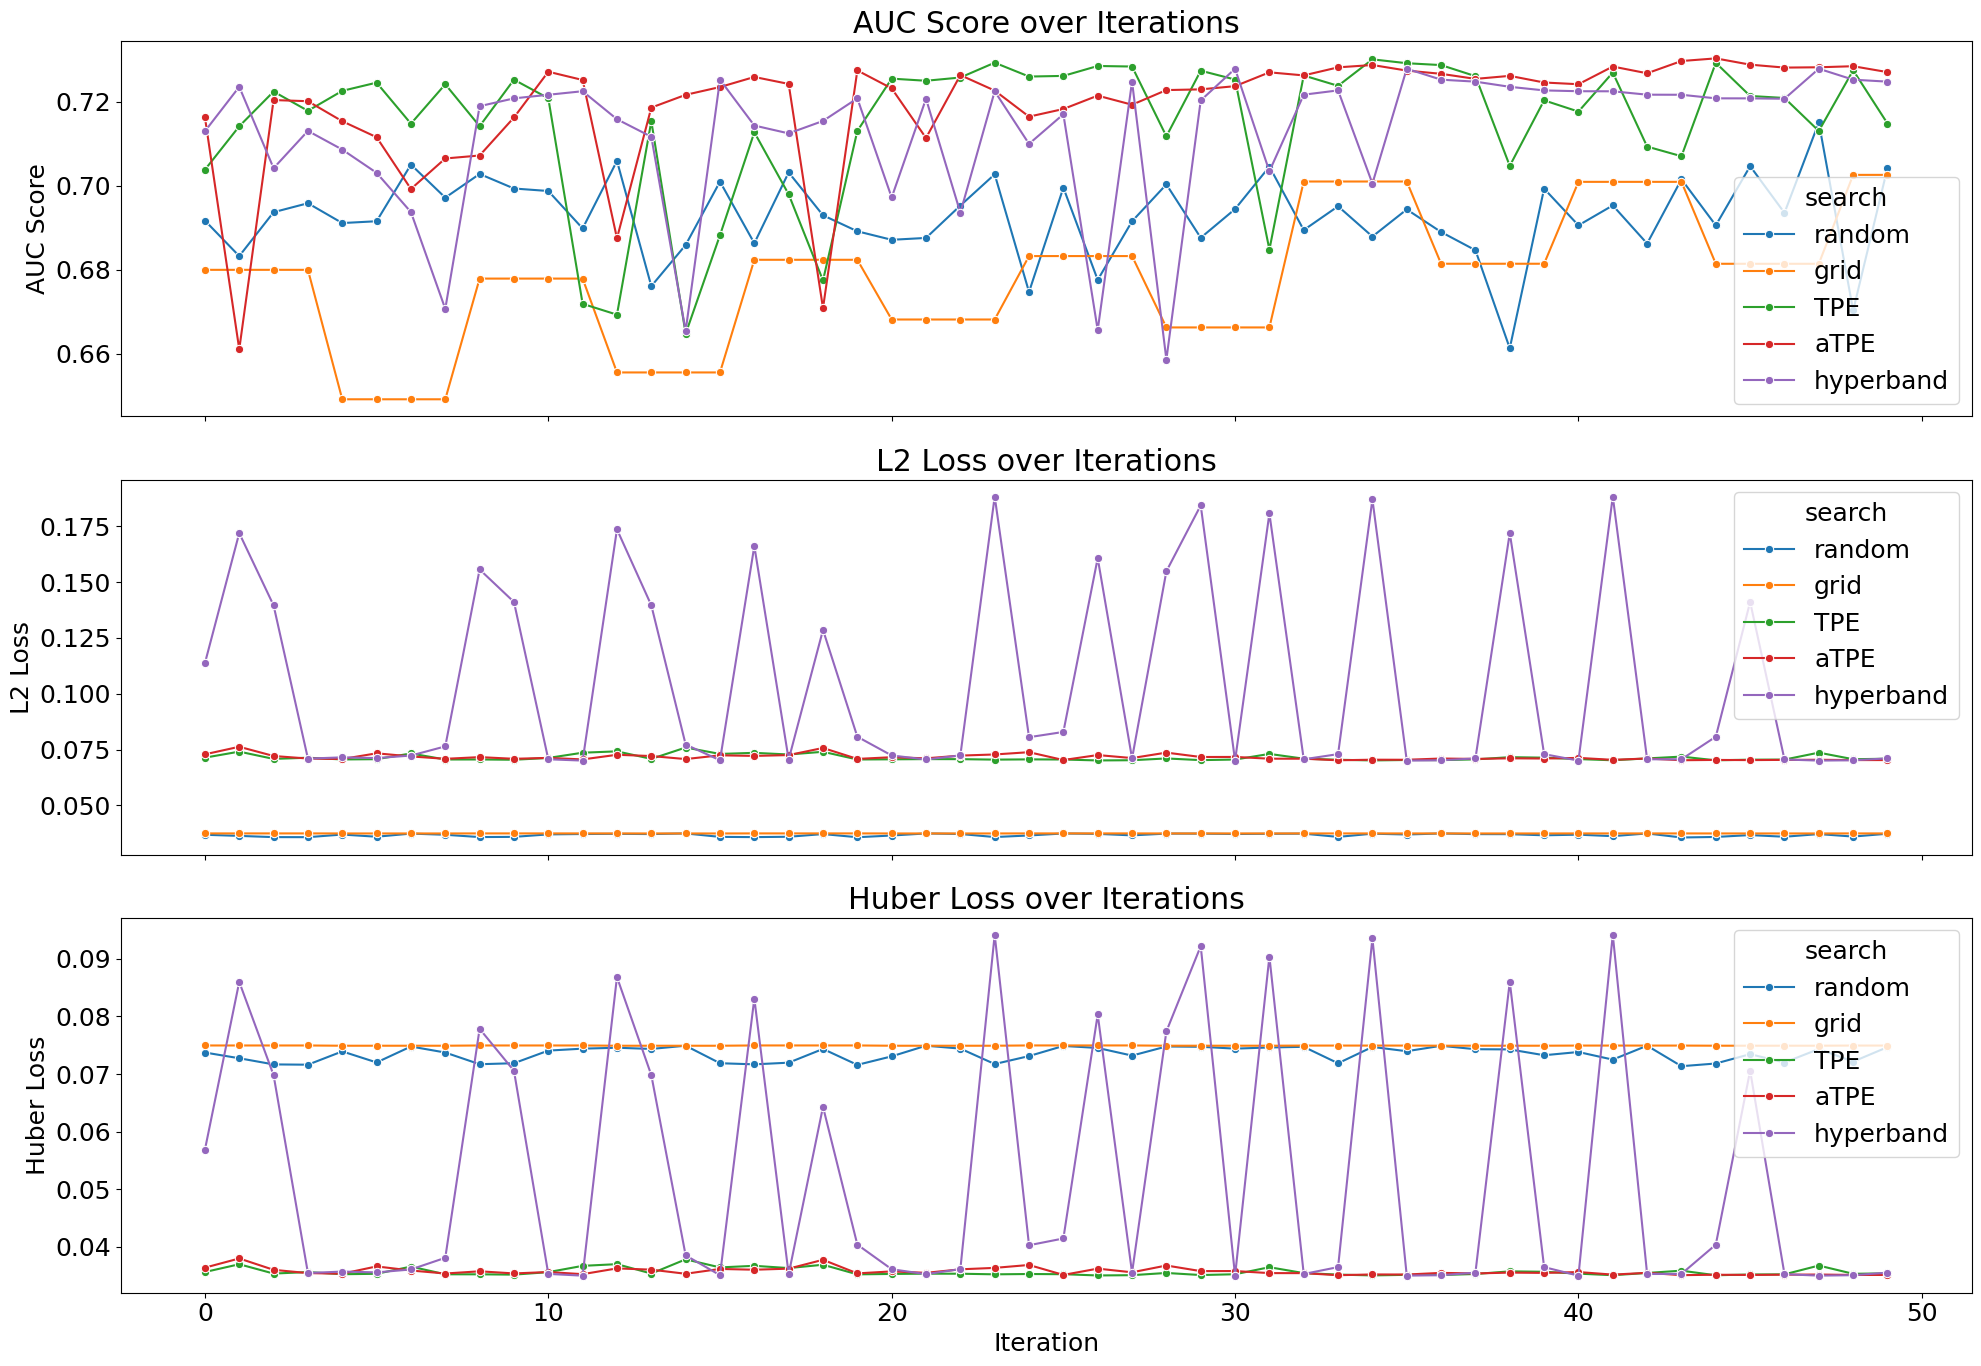

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 14), sharex=True)

sns.lineplot(data=hyp, x='iteration', y='auc_score', hue='search', marker='o', ax=axes[0])
axes[0].set_title('AUC Score over Iterations')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('AUC Score')

sns.lineplot(data=hyp, x='iteration', y='l2_score', hue='search', marker='o', ax=axes[1])
axes[1].set_title('L2 Loss over Iterations')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('L2 Loss')

sns.lineplot(data=hyp, x='iteration', y='huber_score', hue='search', marker='o', ax=axes[2])
axes[2].set_title('Huber Loss over Iterations')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Huber Loss')

plt.tight_layout()
plt.show()

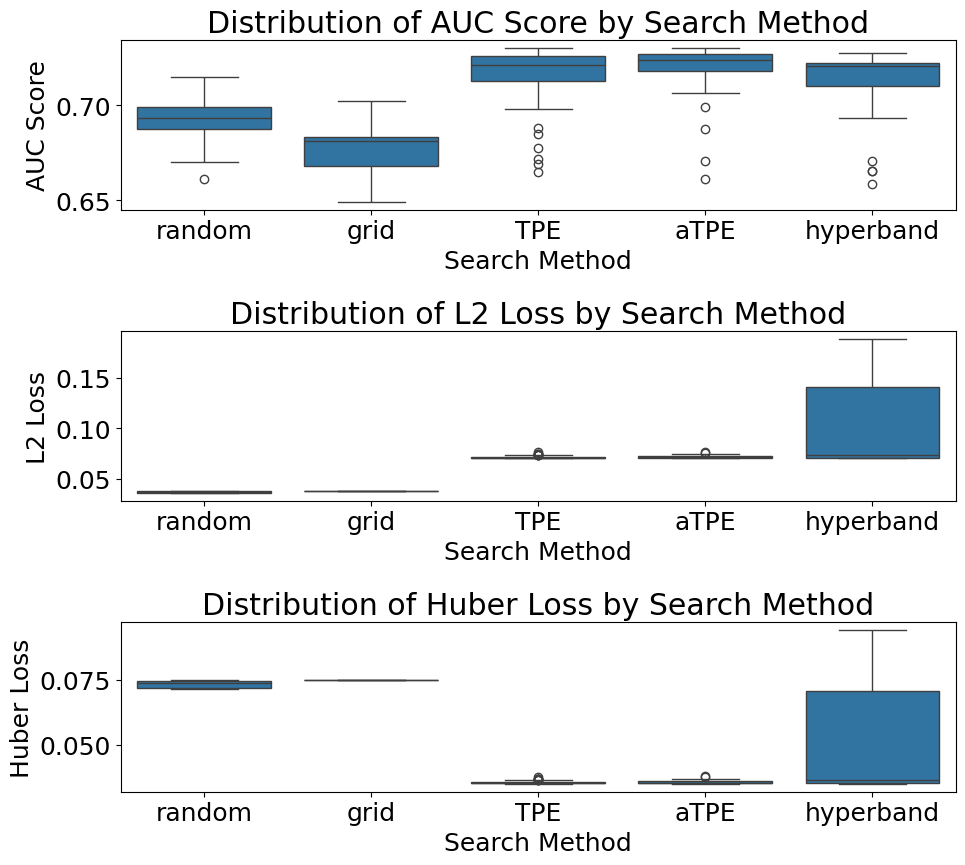

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 9))

sns.boxplot(data=hyp, x='search', y='auc_score', ax=axes[0])
axes[0].set_title('Distribution of AUC Score by Search Method')
axes[0].set_xlabel('Search Method')
axes[0].set_ylabel('AUC Score')

sns.boxplot(data=hyp, x='search', y='l2_score', ax=axes[1])
axes[1].set_title('Distribution of L2 Loss by Search Method')
axes[1].set_xlabel('Search Method')
axes[1].set_ylabel('L2 Loss')

sns.boxplot(data=hyp, x='search', y='huber_score', ax=axes[2])
axes[2].set_title('Distribution of Huber Loss by Search Method')
axes[2].set_xlabel('Search Method')
axes[2].set_ylabel('Huber Loss')

plt.tight_layout()
plt.show()

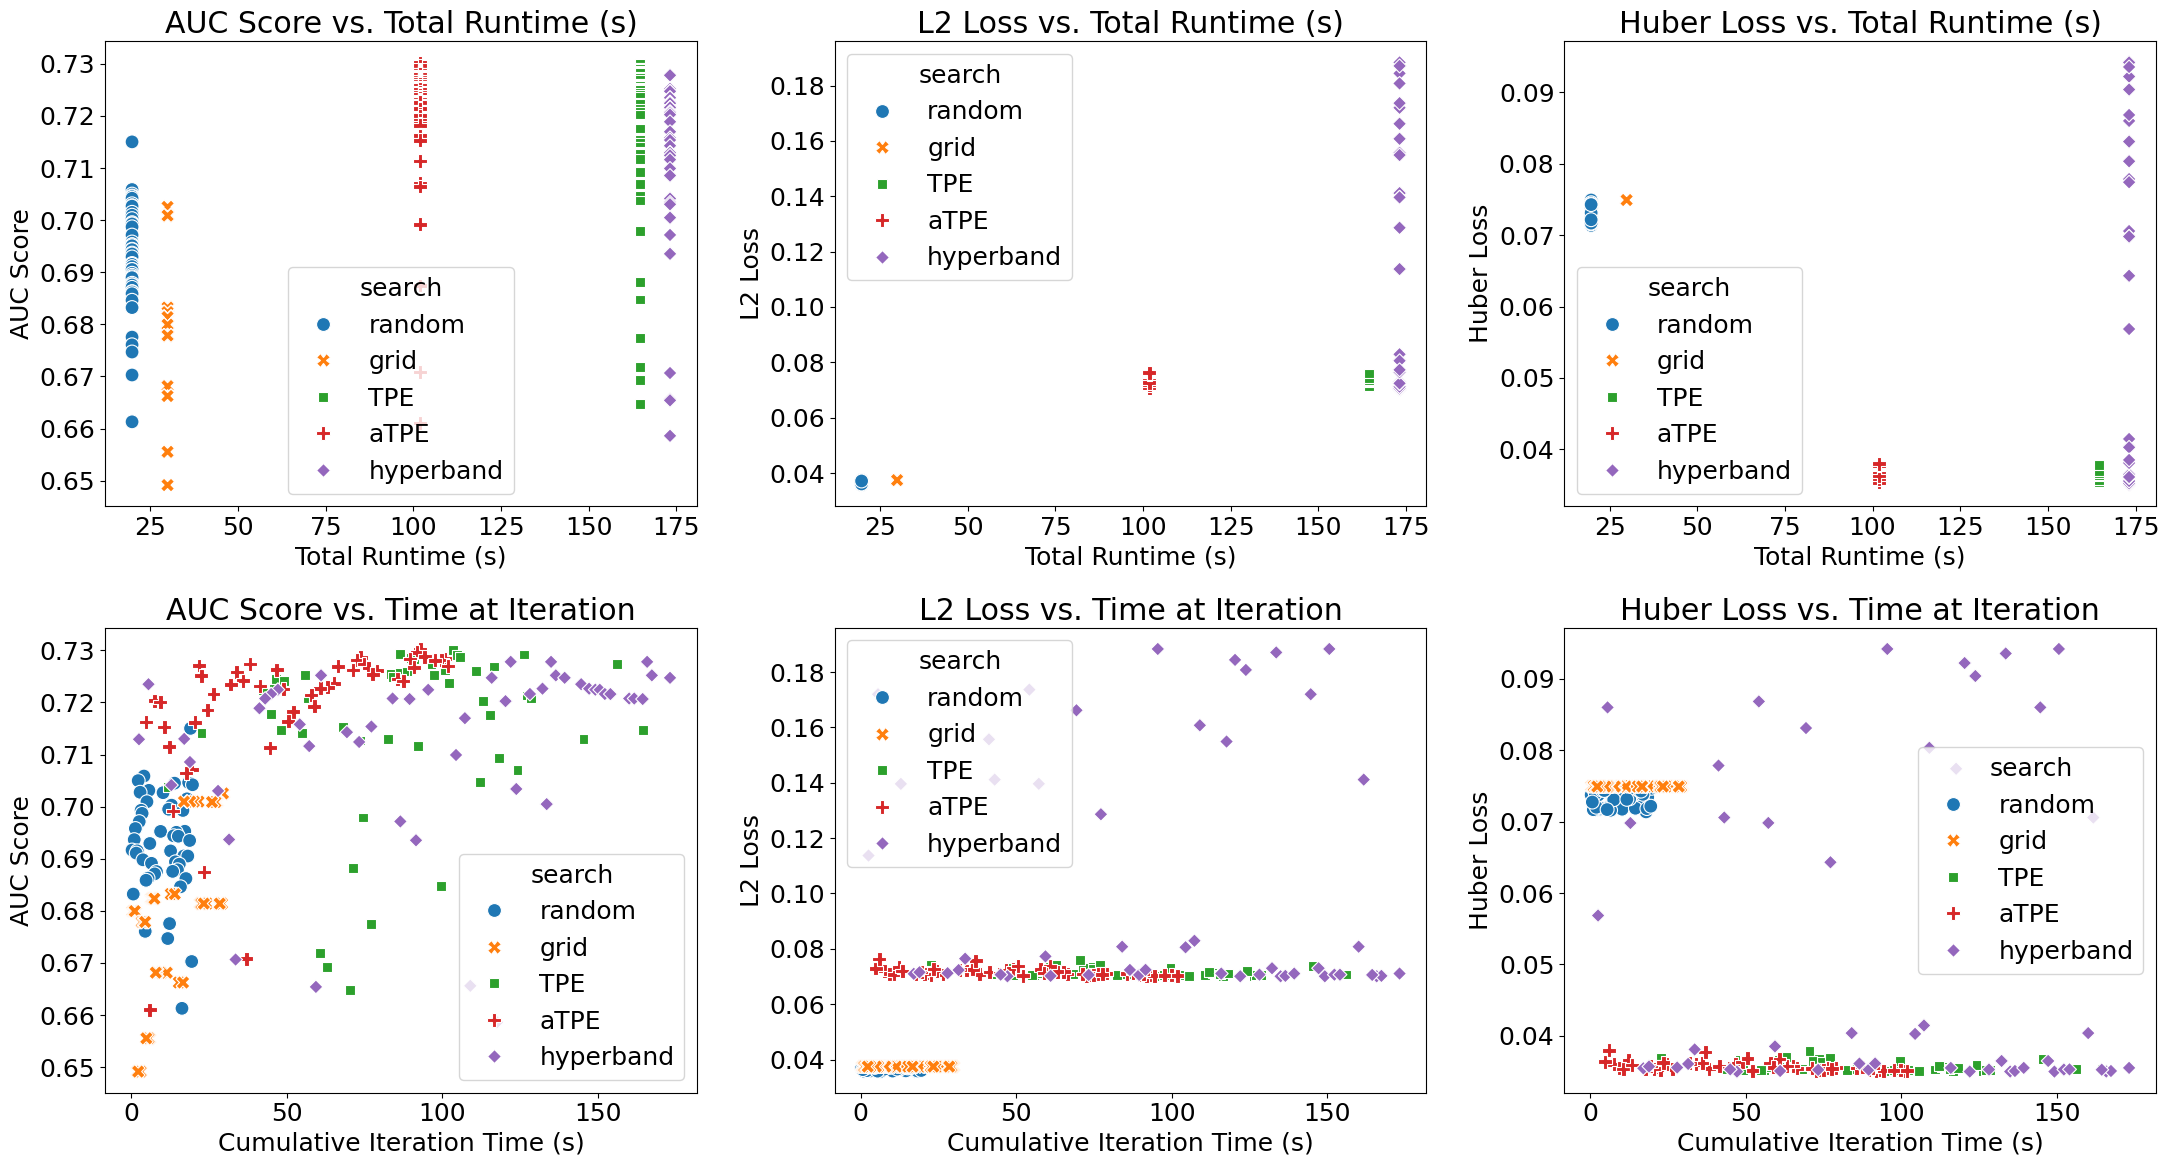

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(22, 12))

sns.scatterplot(data=hyp, x='total_runtime', y='auc_score', hue='search', style='search', s=100, ax=axes[0, 0])
axes[0, 0].set_title('AUC Score vs. Total Runtime (s)')
axes[0, 0].set_xlabel('Total Runtime (s)')
axes[0, 0].set_ylabel('AUC Score')

sns.scatterplot(data=hyp, x='total_runtime', y='l2_score', hue='search', style='search', s=100, ax=axes[0, 1])
axes[0, 1].set_title('L2 Loss vs. Total Runtime (s)')
axes[0, 1].set_xlabel('Total Runtime (s)')
axes[0, 1].set_ylabel('L2 Loss')

sns.scatterplot(data=hyp, x='total_runtime', y='huber_score', hue='search', style='search', s=100, ax=axes[0, 2])
axes[0, 2].set_title('Huber Loss vs. Total Runtime (s)')
axes[0, 2].set_xlabel('Total Runtime (s)')
axes[0, 2].set_ylabel('Huber Loss')

sns.scatterplot(data=hyp, x='time_after_iteration', y='auc_score', hue='search', style='search', s=100, ax=axes[1, 0])
axes[1, 0].set_title('AUC Score vs. Time at Iteration')
axes[1, 0].set_xlabel('Cumulative Iteration Time (s)')
axes[1, 0].set_ylabel('AUC Score')

sns.scatterplot(data=hyp, x='time_after_iteration', y='l2_score', hue='search', style='search', s=100, ax=axes[1, 1])
axes[1, 1].set_title('L2 Loss vs. Time at Iteration')
axes[1, 1].set_xlabel('Cumulative Iteration Time (s)')
axes[1, 1].set_ylabel('L2 Loss')

sns.scatterplot(data=hyp, x='time_after_iteration', y='huber_score', hue='search', style='search', s=100, ax=axes[1, 2])
axes[1, 2].set_title('Huber Loss vs. Time at Iteration')
axes[1, 2].set_xlabel('Cumulative Iteration Time (s)')
axes[1, 2].set_ylabel('Huber Loss')

plt.tight_layout()
plt.show()

## DFs with rows relating to optimal values for each metric

In [ ]:
random_results=random_hyp.copy()
grid_results = grid_hyp.copy()


grid_results['total_runtime'] = grid_results['time_after_iteration'].max()
grid_results


In [ ]:
best_random_inds = [random_hyp['auc_score'].idxmax()] + [random_hyp[loss].idxmin() for loss in ['l2_score', 'huber_score']]
best_bayes_tpe_inds = [bayes_hyp_tpe['auc_score'].idxmax()] + [bayes_hyp_tpe[loss].idxmin() for loss in ['l2_score', 'huber_score']]
best_bayes_atpe_inds = [bayes_hyp_atpe['auc_score'].idxmax()] + [bayes_hyp_atpe[loss].idxmin() for loss in ['l2_score', 'huber_score']]
best_grid_inds = [grid_hyp['auc_score'].idxmax()] + [grid_hyp[loss].idxmin() for loss in ['l2_score', 'huber_score']]

best_random_params = random_hyp.iloc[best_random_inds, :].copy()
best_bayes_tpe_params = bayes_hyp_tpe.iloc[best_bayes_tpe_inds, :].copy()
best_bayes_atpe_params = bayes_hyp_atpe.iloc[best_bayes_atpe_inds, :].copy()
best_grid_params = grid_hyp.iloc[best_grid_inds, :].copy()

hyp = pd.concat([best_random_params, best_grid_params, best_bayes_tpe_params, best_bayes_atpe_params], ignore_index=True)
hyp.head(50)

In [ ]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 4)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 4)
sns.kdeplot(bayes_results['learning_rate'], label = 'Bayes Optimization', linewidth = 4)
plt.vlines([best_random_params['learning_rate'], best_bayes_params['learning_rate']],
           ymin = 0.0, ymax = 10.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

In [ ]:
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'n_estimators', 'auc_score', 'is_unbalance', 'l2_score', 'huber_score', 'runtime', 'time_after_iteration',
                    'boosting_type', 'iteration', 'subsample', 'metric', 'verbose', 'loss', 'learning_rate']:
        plt.figure(figsize = (14, 6))
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution', linewidth = 4)
        sns.kdeplot(random_params[hyper], label = 'Random Search', linewidth = 4)
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization', linewidth = 4)
        plt.vlines([best_random_params[hyper], best_bayes_params[hyper]],
                     ymin = 0.0, ymax = 10.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();